# B&O Model Checking For The Medium-Variance-Shift Case

Bastos & O'Hagan provided a great set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to be able to discern whether all curves are drawn from the same simulator. 

This notebook implements B&O diagnostics for the case where we are trying to fit data from three different GPs, all of which have the same length scale, but have different variances: of 1, 3, and 0.33 respectively. (Other shift factors can be implemented easily, but results shown and commented on are for factor 3 case.)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import xarray as xa
import scipy.stats as stats
from scipy.special import loggamma
from statsmodels.sandbox.distributions.mv_normal import MVT
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import wraps
from cycler import cycler
from itertools import cycle
# from fastcache import lru_cache
import inspect
import gsum
from gsum import rbf, default_attributes, cholesky_errors, mahalanobis, lazy_property, pivoted_cholesky
from gsum import ConjugateGaussianProcess, ConjugateStudentProcess, Diagnostic, GraphicalDiagnostic

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

%load_ext Cython
%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 120

Begin by drawing a set of curves from a GP, then pick a set of points to fit to. Below are the parameters one might want to adjust:

In [3]:
X_full = np.atleast_2d(np.linspace(0, 20, 41)).T
mask = np.array([i % 3 == 0 for i in range(len(X_full))])

n_samples = 4
n_ref = 1000
nugget_sd = 1e-4
sd_true = 1.0
ls_true = 3

true_kernel = C(sd_true, (1e-3, 1e3)) * RBF(ls_true, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel
#orders = np.arange(n_samples)
#ratio = 0.5  # Expansion parameter

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

basevariance=1.0; varianceshiftfactor=3; baselengthscale=3; lengthscaleshift=0

shiftvarup_kernel=C(basevariance*varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvardown_kernel=C(basevariance/varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthup_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale+lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthdown_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale-lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

gp1 = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None,)
gp2 = GaussianProcessRegressor(kernel=shiftvarup_kernel,n_restarts_optimizer=9, optimizer=None)
gp3 = GaussianProcessRegressor(kernel=shiftvardown_kernel,n_restarts_optimizer=9, optimizer=None)

## First example

We generate our first data set

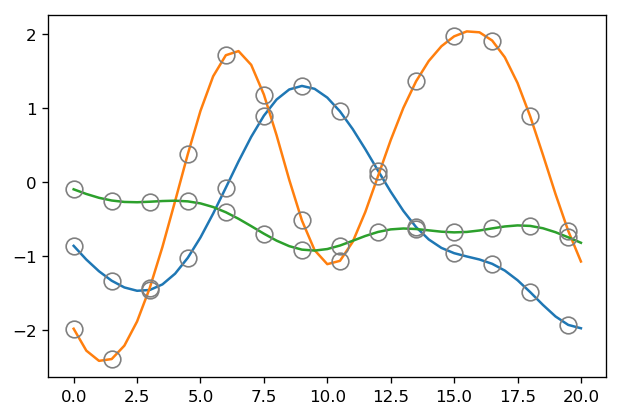

In [4]:
# Instantiate a Gaussian Process model

# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=5; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

toy_data = toy_data_full[:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Remember: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

1.4450308373875742


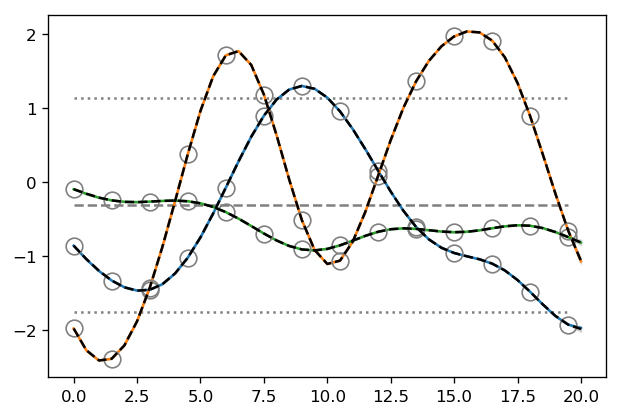

In [7]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
toy_data_test = toy_data_full[:, ~mask]

#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
X_test = X_full[~mask]
# my_gp.beta()
m_pred, K_pred = my_gp.predict(X_full, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_test, note that a nugget should be added to fitcov_full when it is used below.
#fitmean_full = my_gp.mean(X_new) 
#fitcov_full = my_gp.cov(X_new,X_new) 
fitmean_test = my_gp.mean(X_test)
fitcov_test = my_gp.cov(X_test,X_test)
print(my_gp.sd())

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_full.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_full.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

This time the standard deviation still comes out a bit larger than one. Postpone model checking until after length-scale estimation. 

### Learning the length scale for this first example

Now we will do the length-scale learning for this first medium-variance-shift case

In [8]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 2.957575757575758}


This time the length scale comes about a little bit, but not disturbingly, low. 

How will the diagnostics look?

Setting kernel kwargs to {'ls': 2.957575757575758}


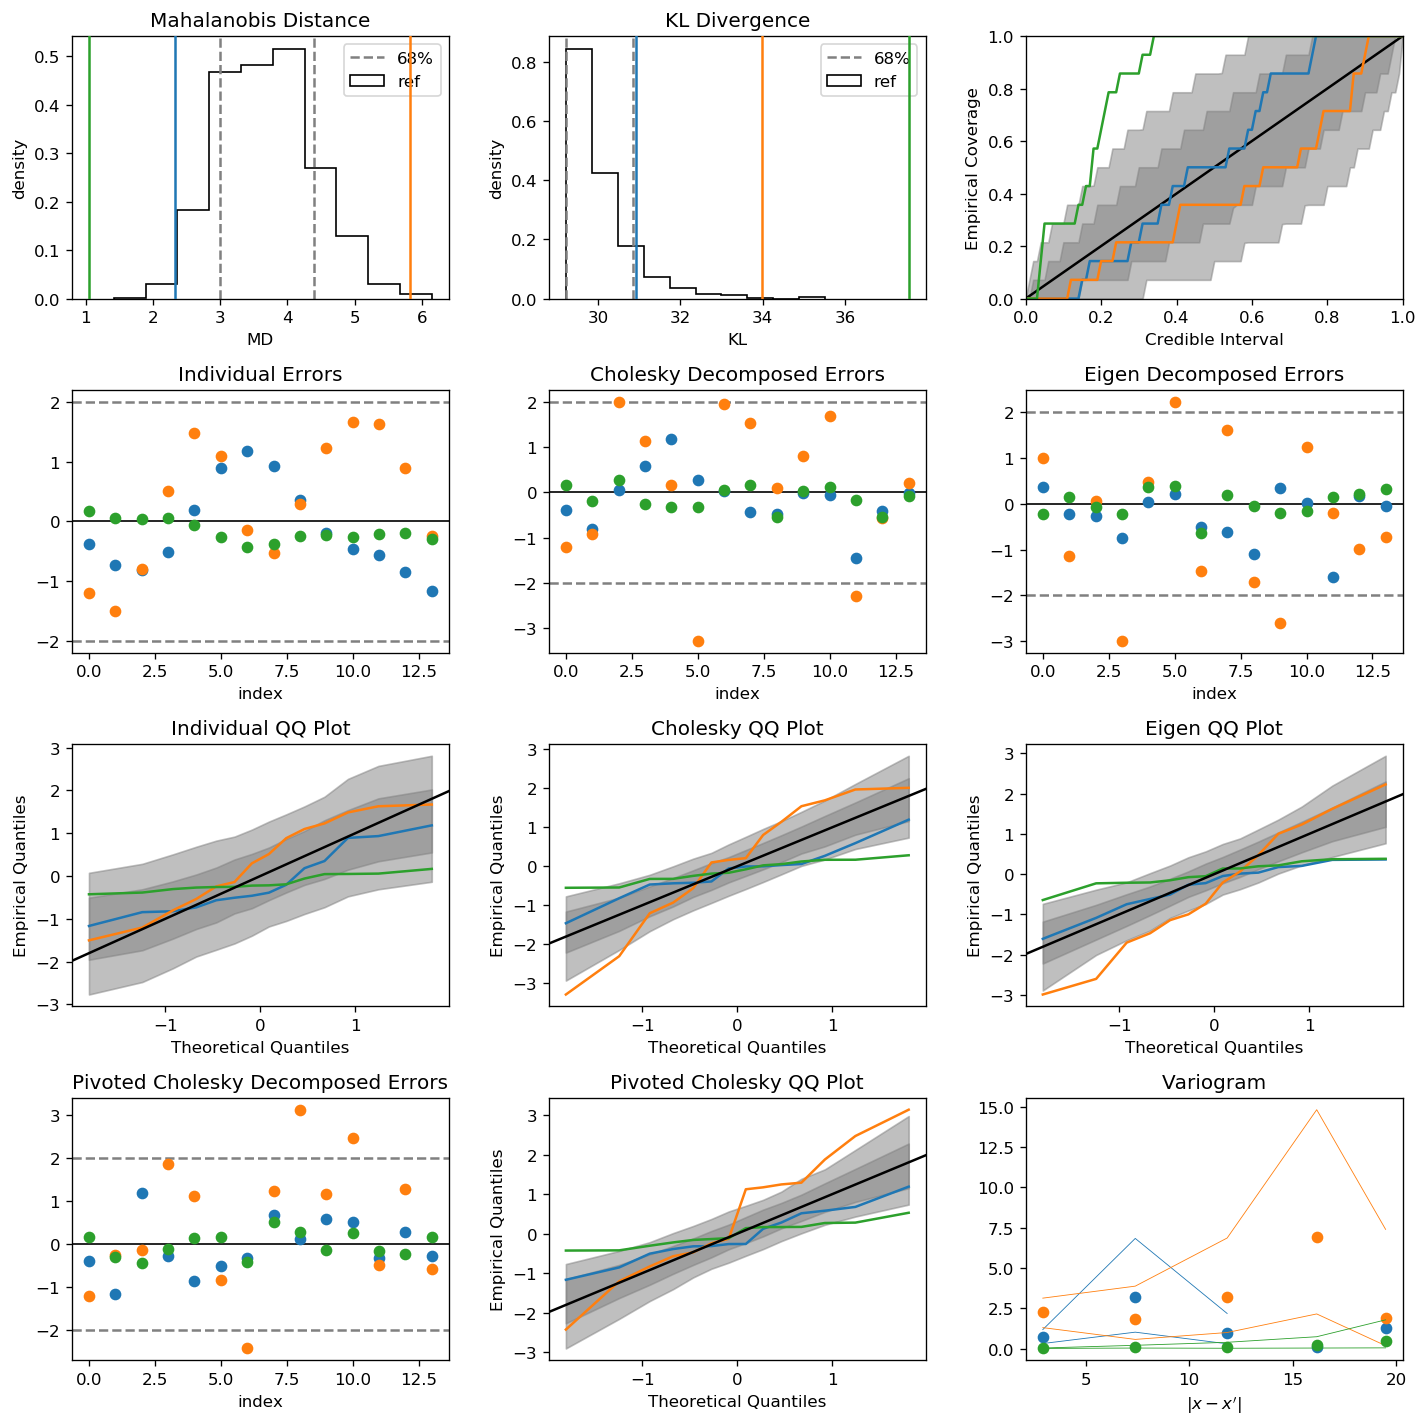

In [9]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()
fitmean_test = gp.mean(X_test) 
fitcov_test = gp.cov(X_test,X_test) 

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

There are too many green errors that are too small and too many orange errors that are too big. This shows up in the Mahalanobis distances.

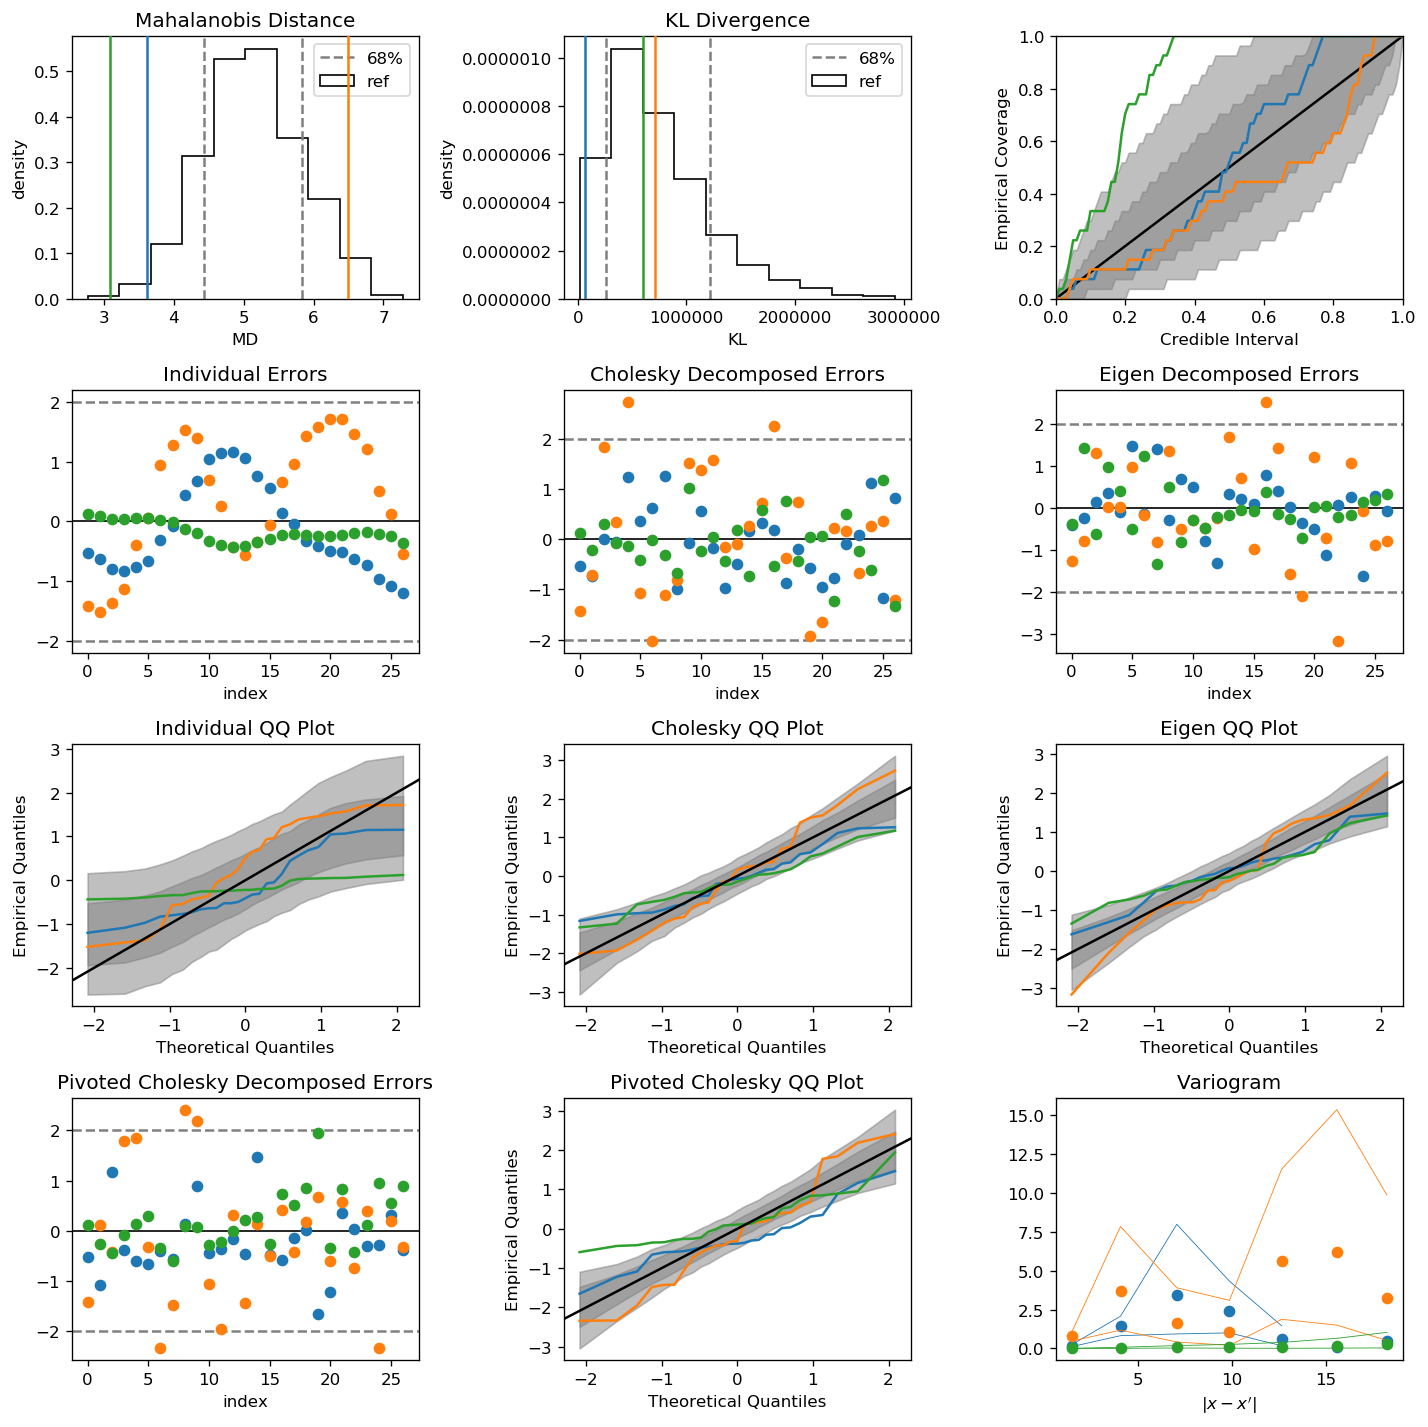

In [10]:
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

DCI plot for green reveals problems. Problems with variance show up at low index in PC decomposed errors and high index in eigen decomposed errors for green & (maybe?) orange [3 out of first 13 errors > 2 sigma]. Blue looks fine there.

What about the interpolants?

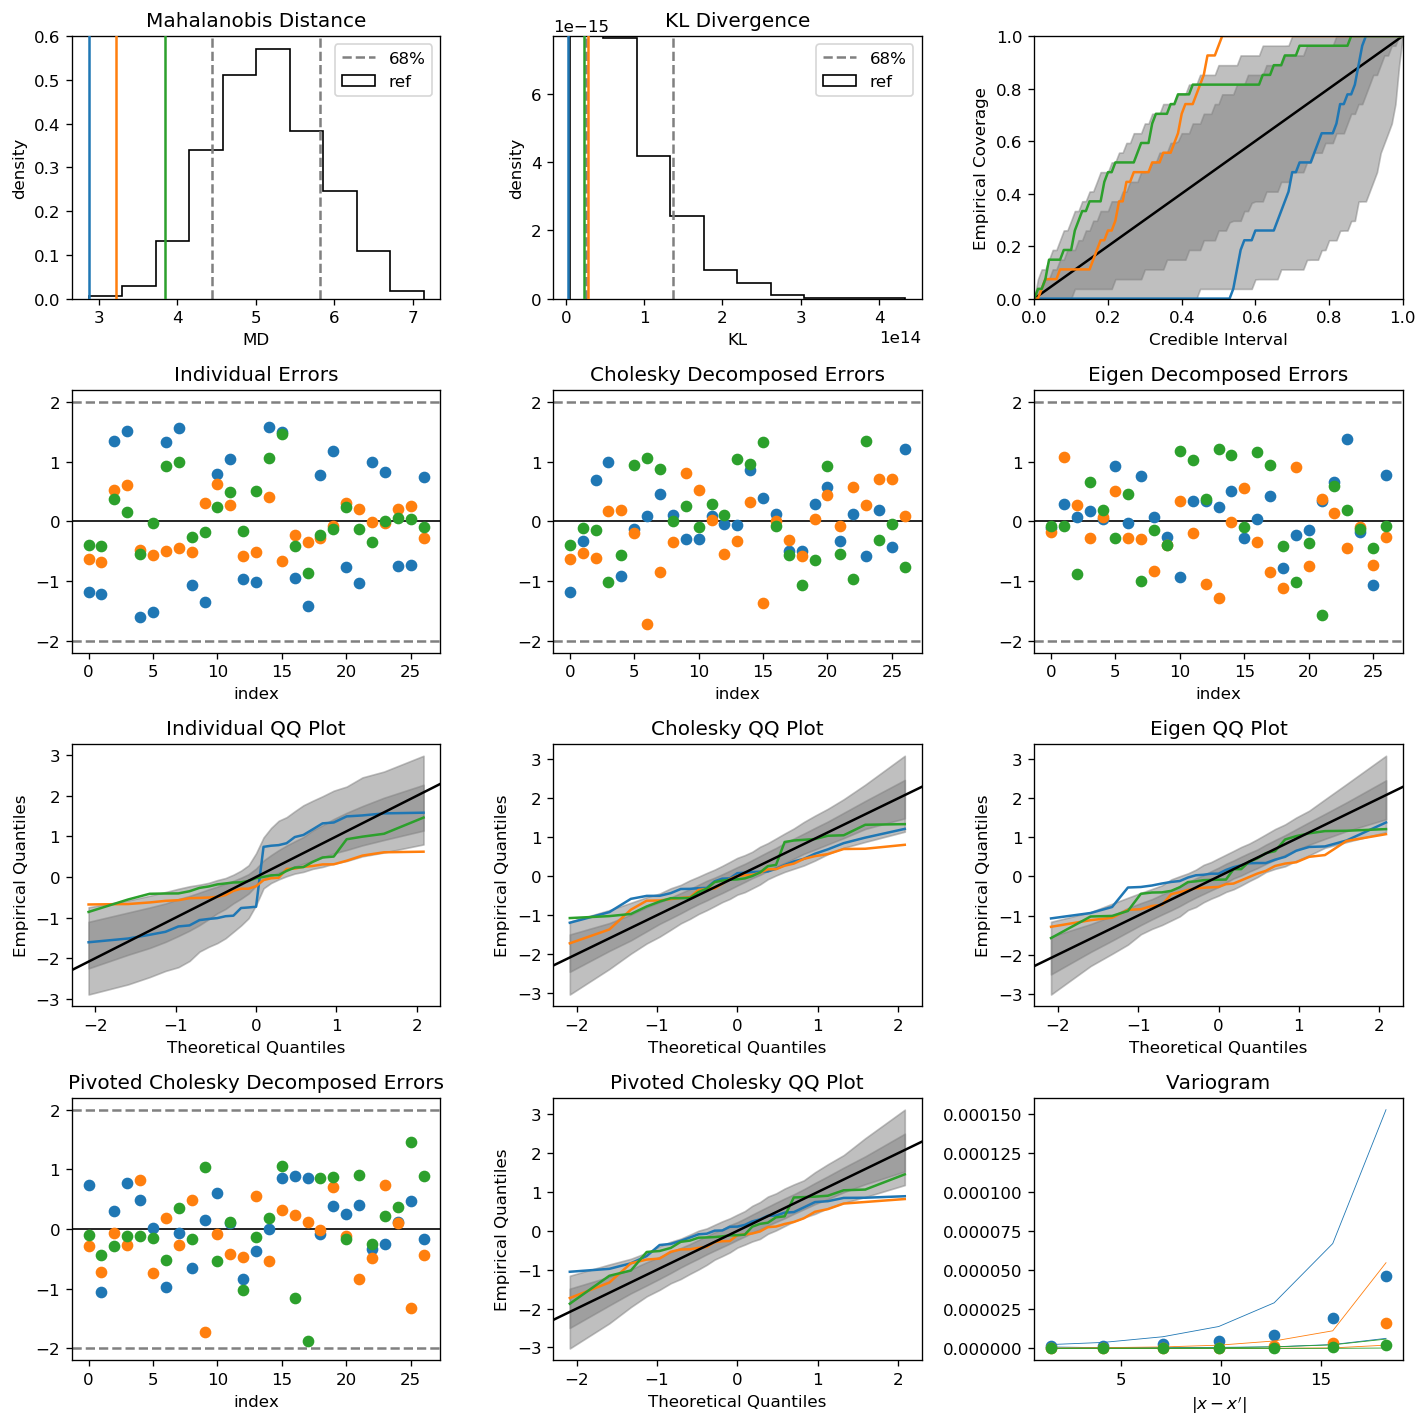

In [11]:
#gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test + nugget_sd**2 * np.eye(cov_test.shape[0]))
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

The interpolants seem to work too well for everything.

## Second example, with a different noise
Now we try with a different seed, to see what changes and what doesn't

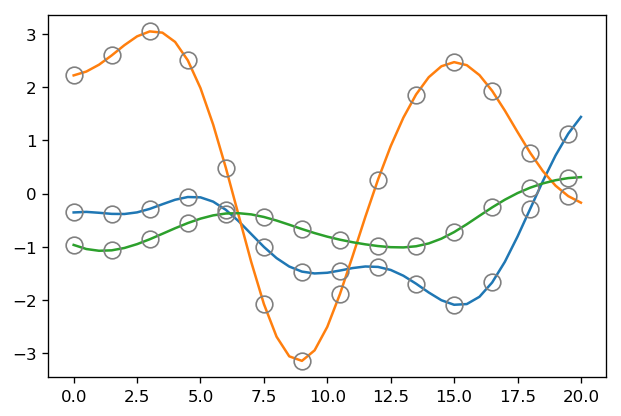

In [12]:
# Instantiate a Gaussian Process model

# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=1; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

toy_data = toy_data_full[:, mask]
toy_data_test=toy_data_full[:,~mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Remember: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Once again, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

0.9690651695500073


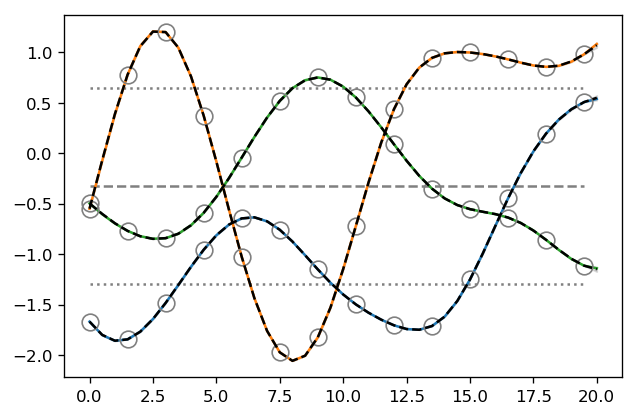

In [30]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
toy_data_pred = toy_data_full[:, ~mask]

#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
X_new = X_full
X_test = X_full[~mask]
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_full, note that a nugget should be added to fitcov_full when it is used below.
fitmean_full = my_gp.mean(X_full) 
fitcov_full = my_gp.cov(X_full,X_full) 
fitmean_test = my_gp.mean(X_test)
fitcov_test = my_gp.cov(X_test,X_test)
print(my_gp.sd())

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_full.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_full.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

This time the standard deviation comes out a bit larger than one.

### Learning the length scale for this second example

Now we will do the length-scale learning for this medium-variance-shift case

Setting kernel kwargs to {'ls': 3.096969696969697}


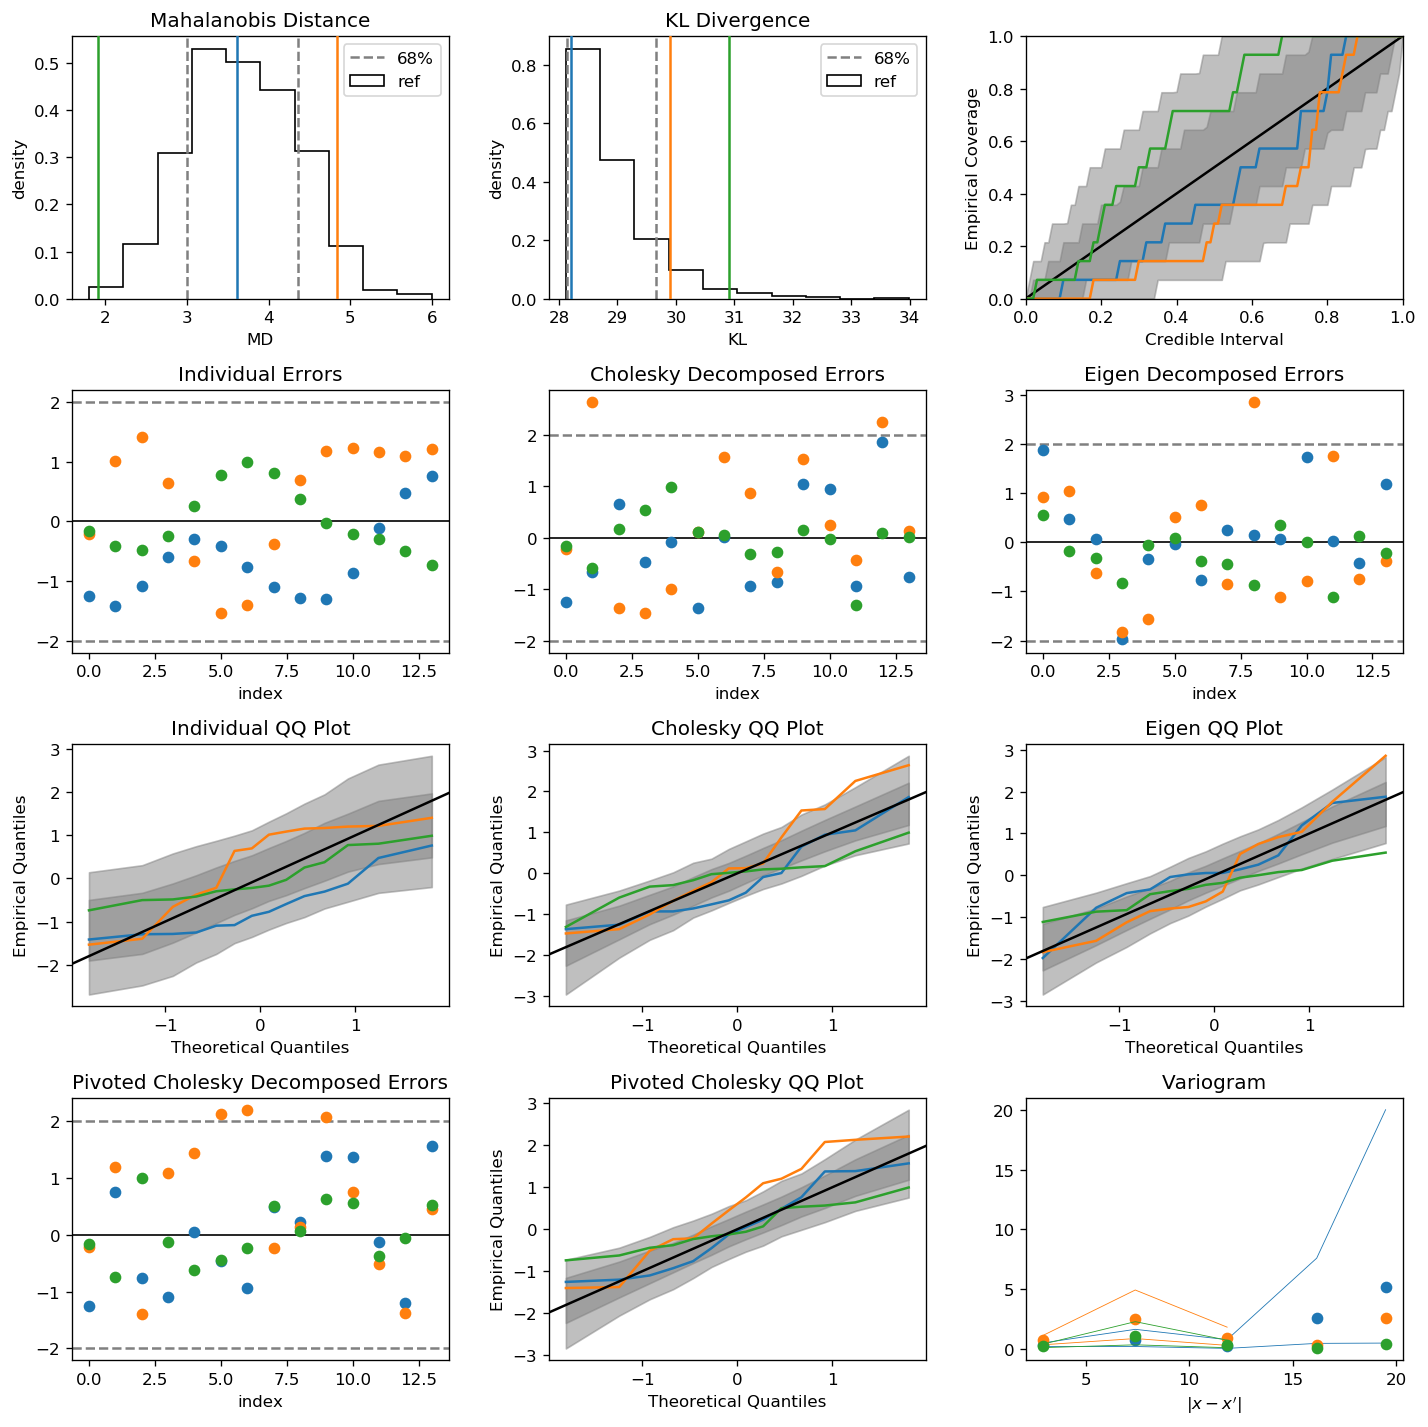

In [29]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()
fitmean_test = gp.mean(X_test) 
fitcov_test = gp.cov(X_test,X_test) 

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

These look more or less as expected. 

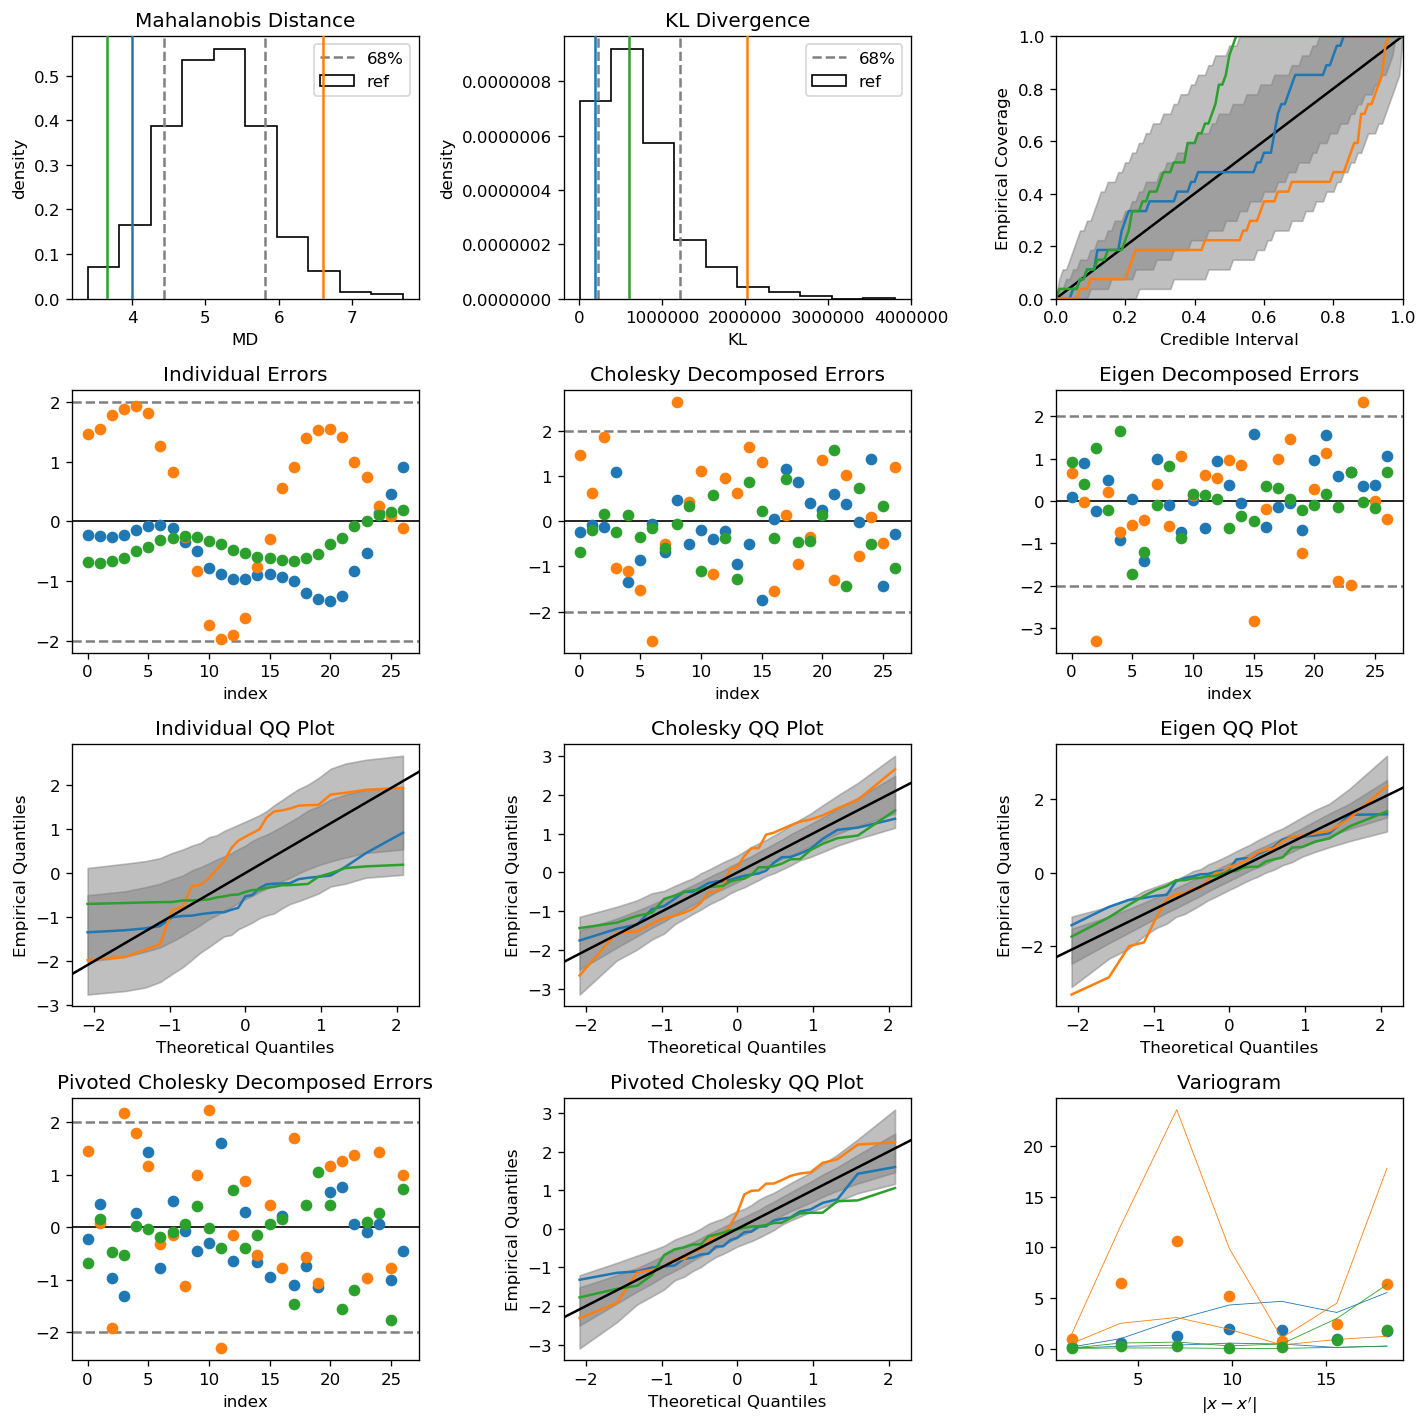

In [16]:
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

These look reassuringly similar to results in old notebook where we a) did not estimate length scale and b) used full data set, not just test data. Quoting from there: "MD for orange curve is again too large. DCI plot does show problems for green though. Eigen decomposed errors again show structure: errors are too large (small) at high index for orange (green). Pivoted Cholesky errors from index 1-[13] show similar issues to eigen-errors at large index. PC QQ plot has orange errors "on the edge". It's noticeable there that the blue errors don't have the correct QQ-plot slope, and that shows up in the eigen-error QQ plot too."

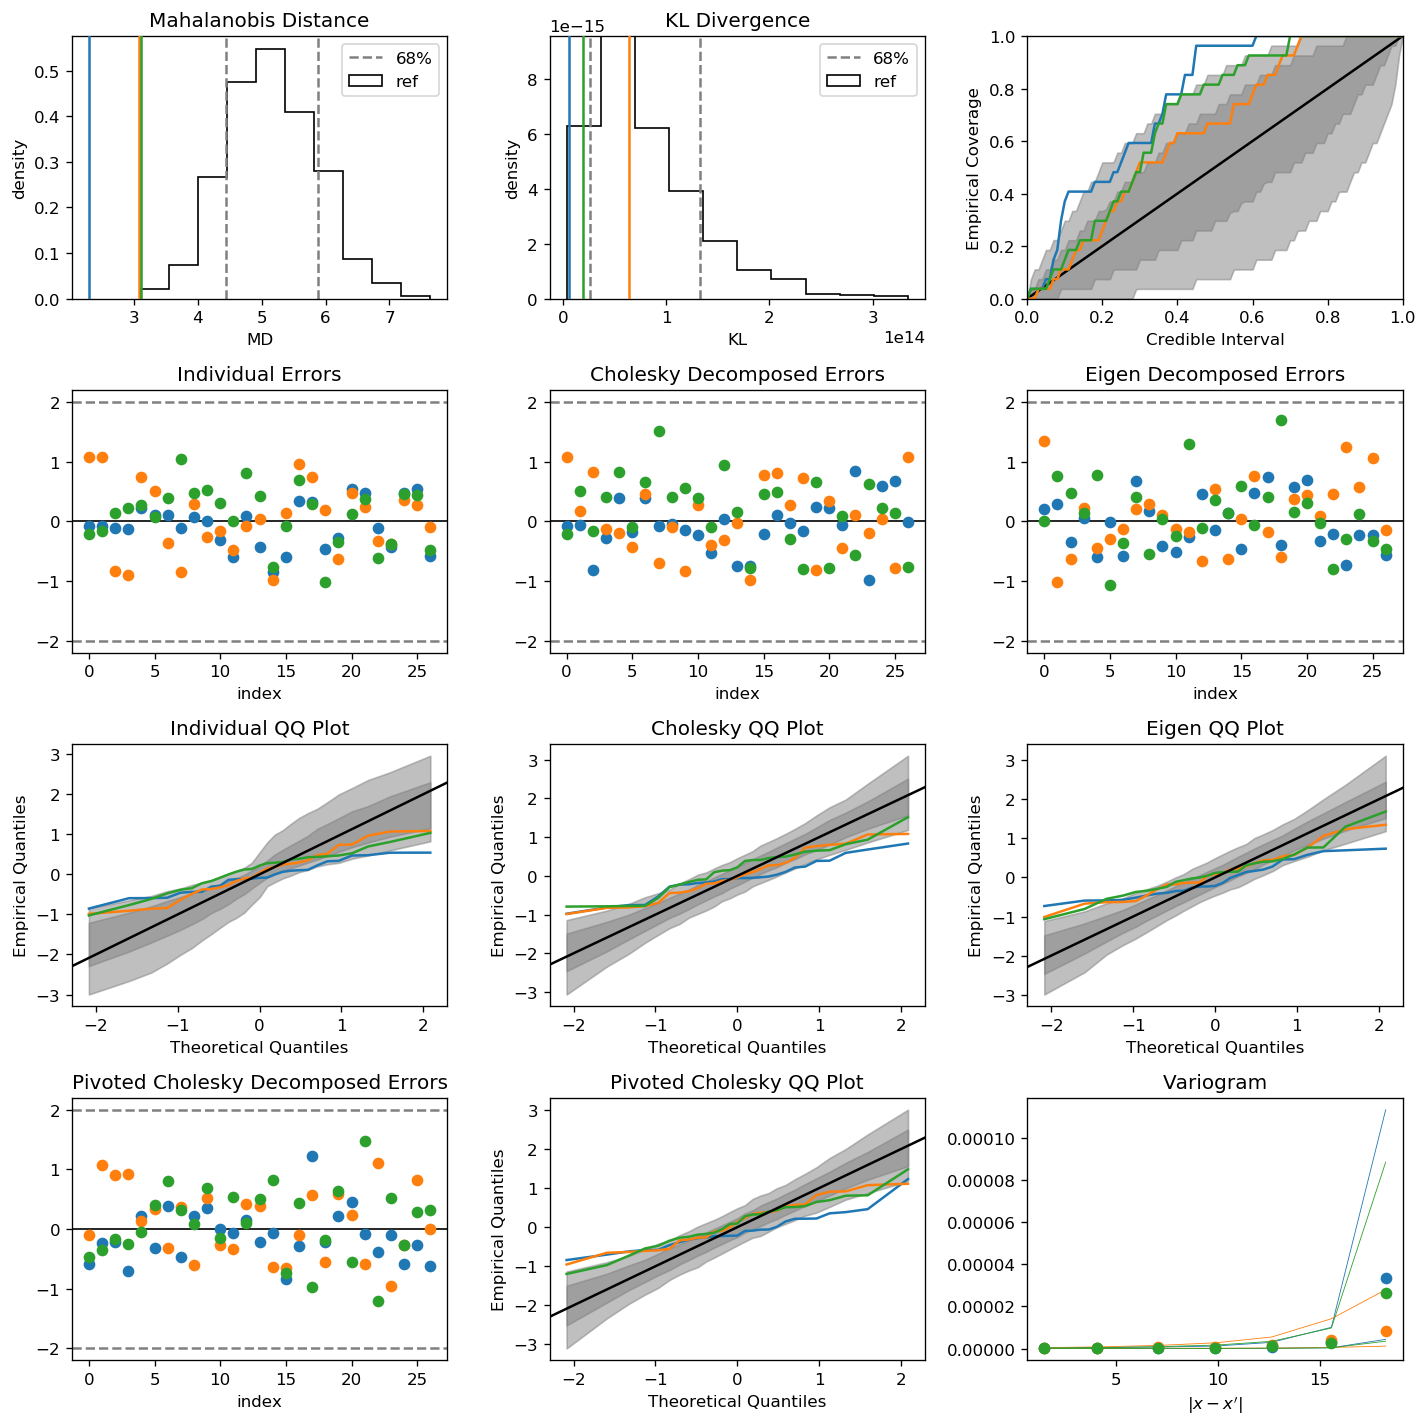

In [17]:
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test + nugget_sd**2 * np.eye(cov_test.shape[0]))
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

Interpolants are again "too good", as reflected in MDs.

## A third noise choice
Now we try with y.a. seed, to see what changes and what doesn't

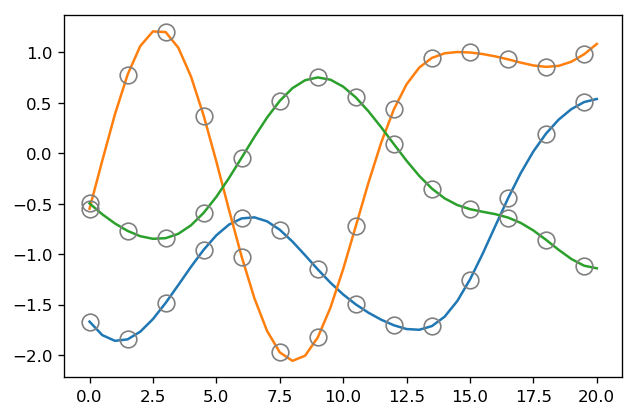

In [18]:
# Instantiate a Gaussian Process model

# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=3; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)


toy_data = toy_data_full[:, mask]
toy_data_test = toy_data_full[:,~mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Remember: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Once again, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

0.9690651695500073


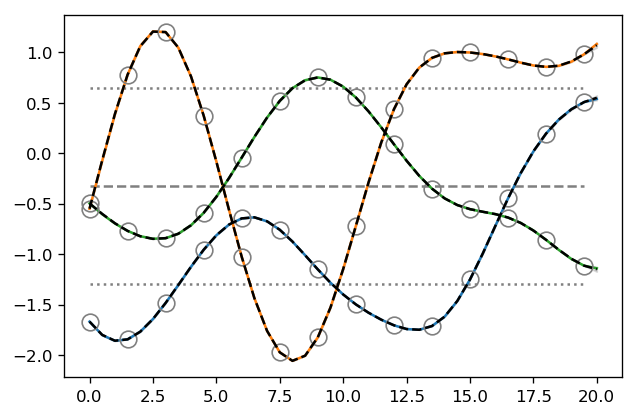

In [25]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
# X_new = X_full[~mask]
# toy_data_pred = toy_data_full[:, ~mask]

#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_full and at the set X_test, note that a nugget should be added to fitcov_full when it is used below.
fitmean_full = my_gp.mean(X_full) 
fitcov_full = my_gp.cov(X_full,X_full) 
fitmean_test = my_gp.mean(X_test)
fitcov_test = my_gp.cov(X_test,X_test)
print(my_gp.sd())

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_full.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

This time the standard deviation is okay but the mean is markedly different from zero. How will this show up in diagnostics?

## Learning the length scale: medium-variance-shift case, y.a. seed

Now we will do the length-scale learning for this third medium-variance-shift case

In [20]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 3.096969696969697}


Length scale is about 3% too big now. How will the diagnostics look?

Setting kernel kwargs to {'ls': 3.096969696969697}


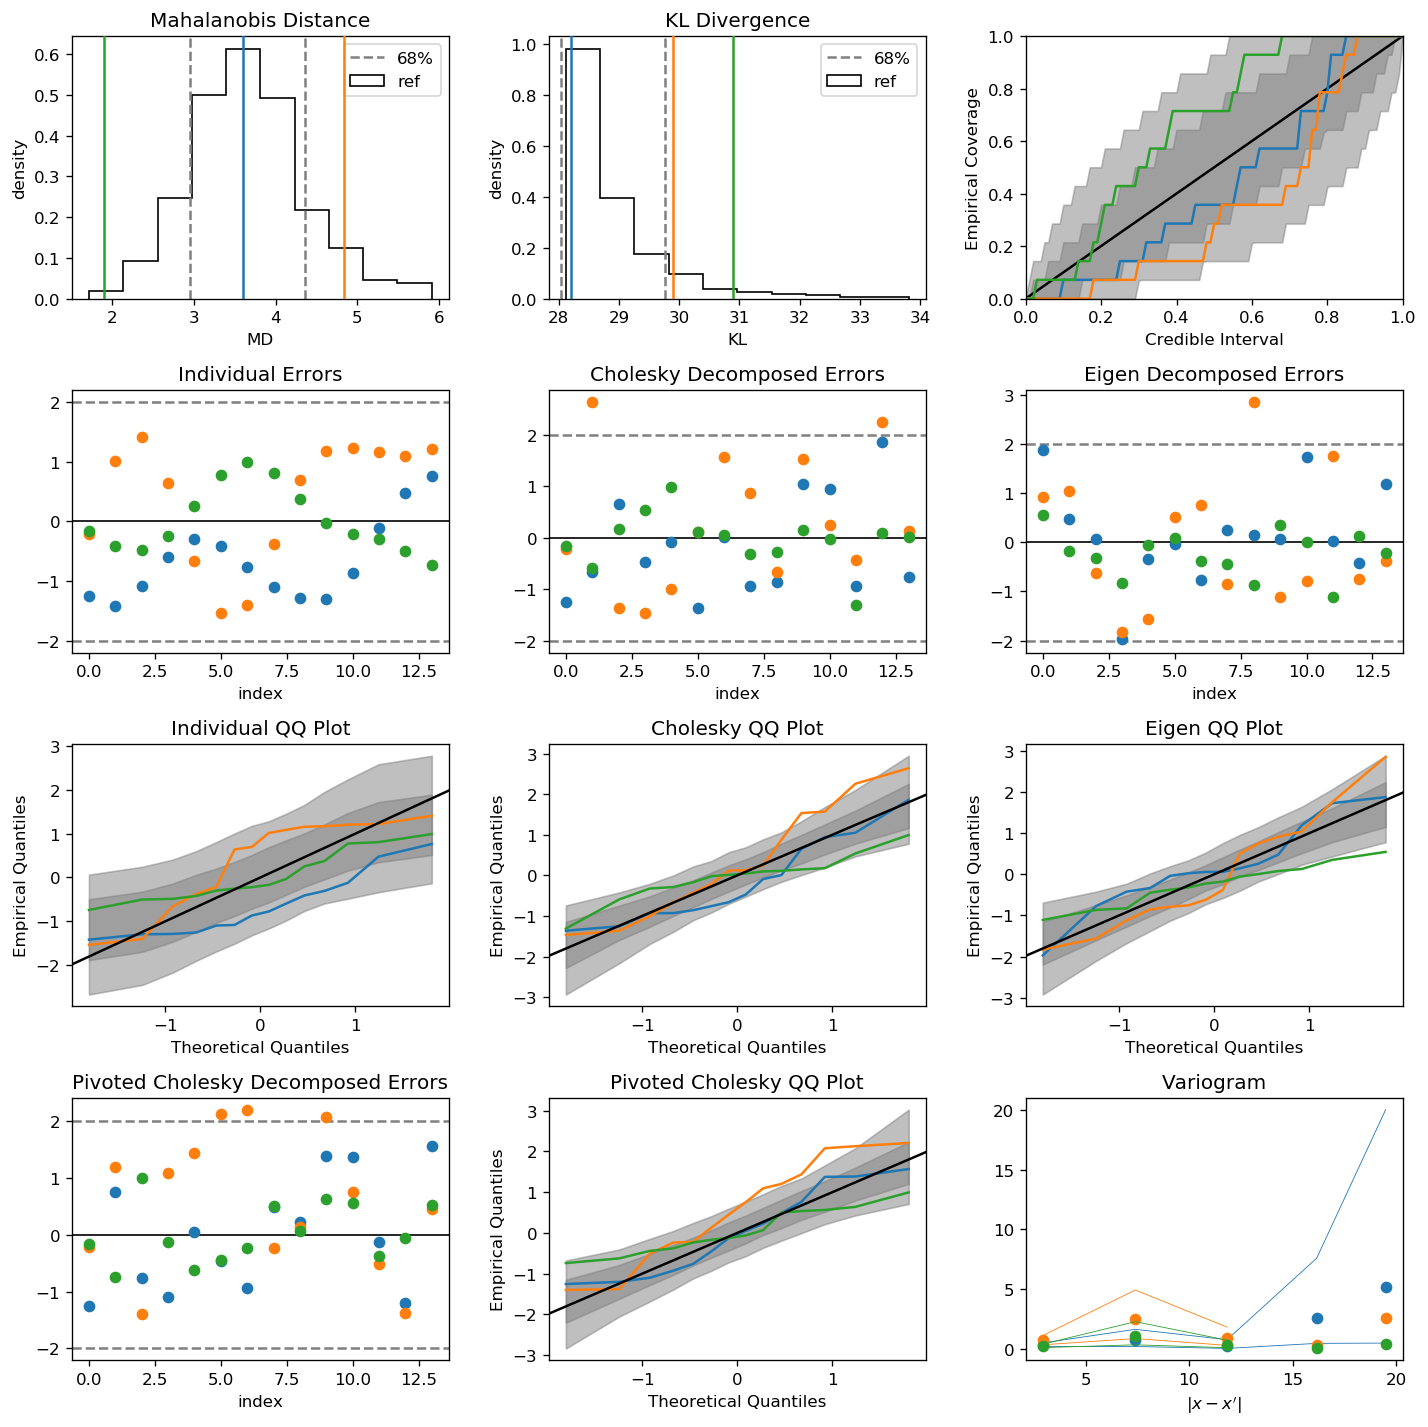

In [26]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()
fitmean_test=gp.mean(X_test)
fitmean_cov=gp.cov(X_test,X_test)

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

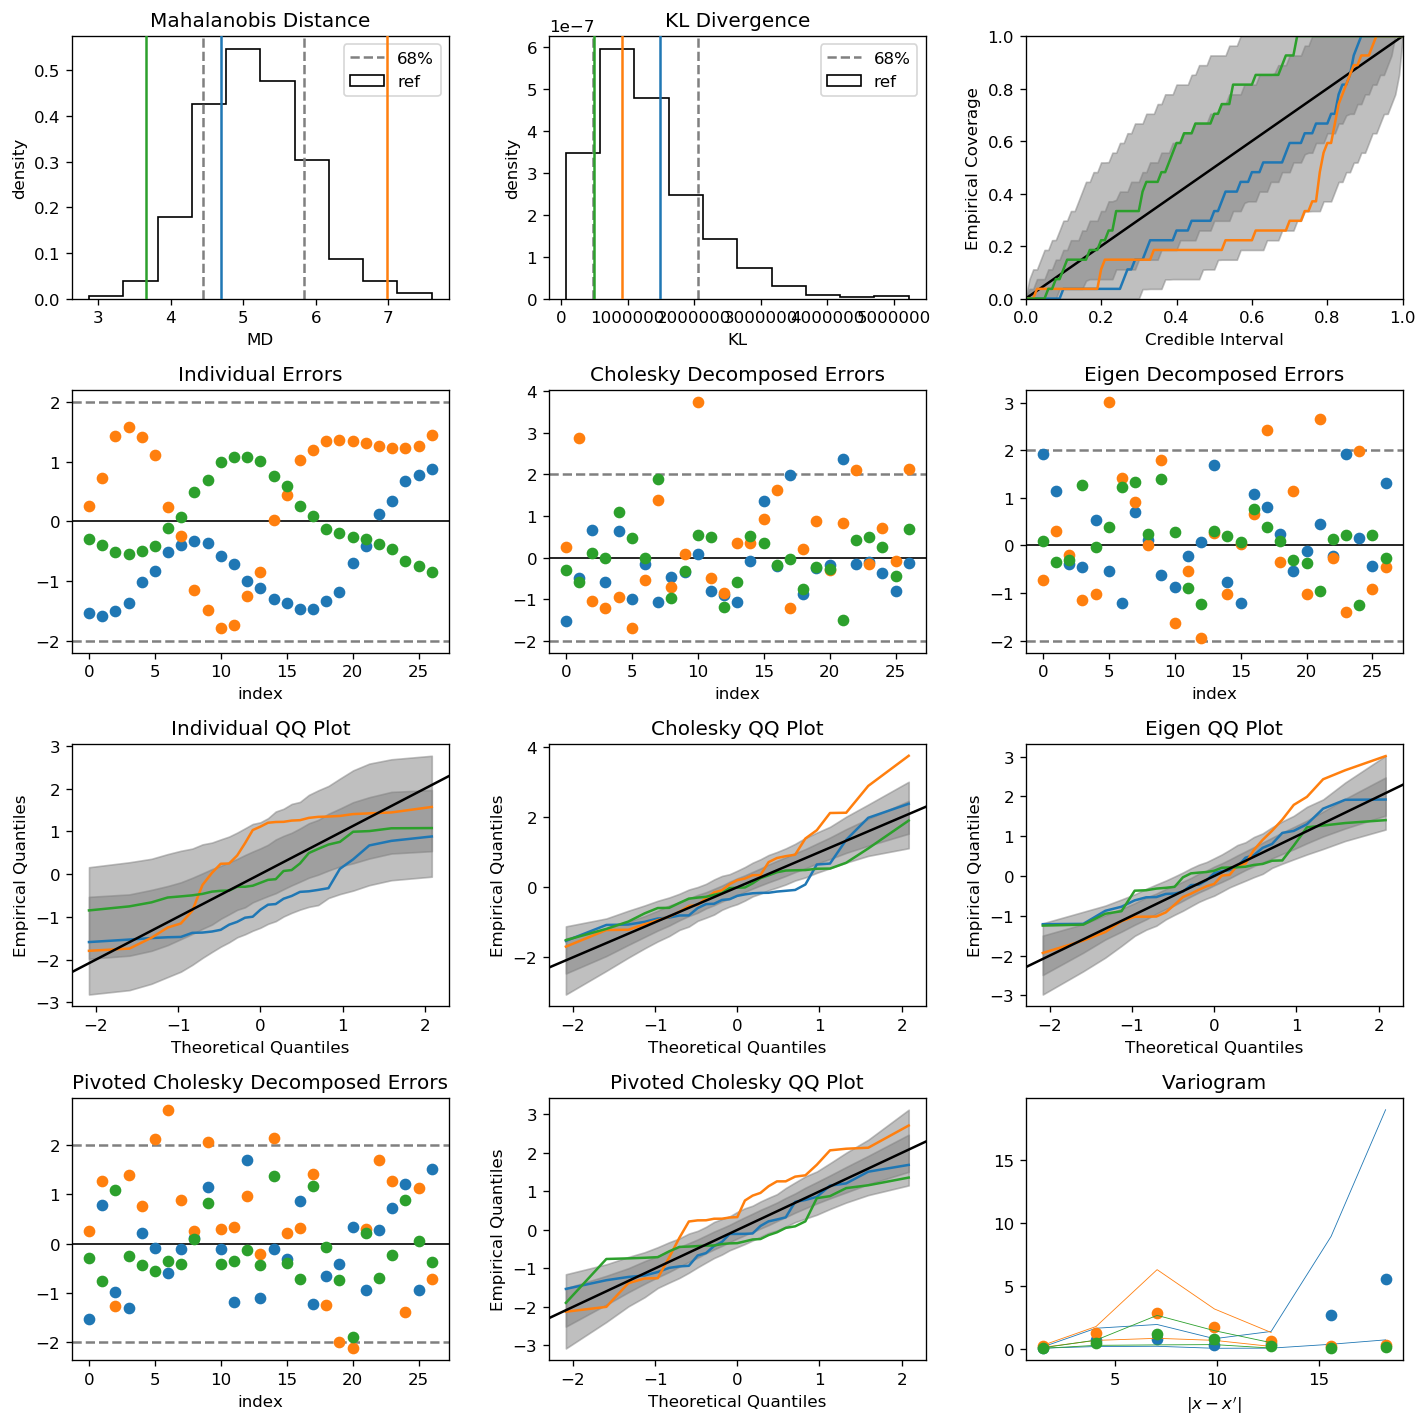

In [27]:
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

MD for orange curve is again too large, that for green is too small. DCI plot  shows problems for green. Eigen decomposed errors again show structure: errors are too large (small) at high index for orange (green). Pivoted Cholesky errors from index 1-13 show similar issues to eigen-errors at large index. PC QQ plot has too many orange errors that are too large (four before index 15), and too many green errors that are too small. Complementary to plot with index! The same issues show up in the eigen error QQ plot.

Compared to cases with significant length-scale misestimation there does not seem to be anytying untoward going on in the diagnostics. So we would hope to be able to separate length-scale misestimation from variance misestimation. 

Note that fact that standard deviation of underlying GP is 0.96 (and not 1.5) allows orange failure to become apparent here. 

Note interpolants again.

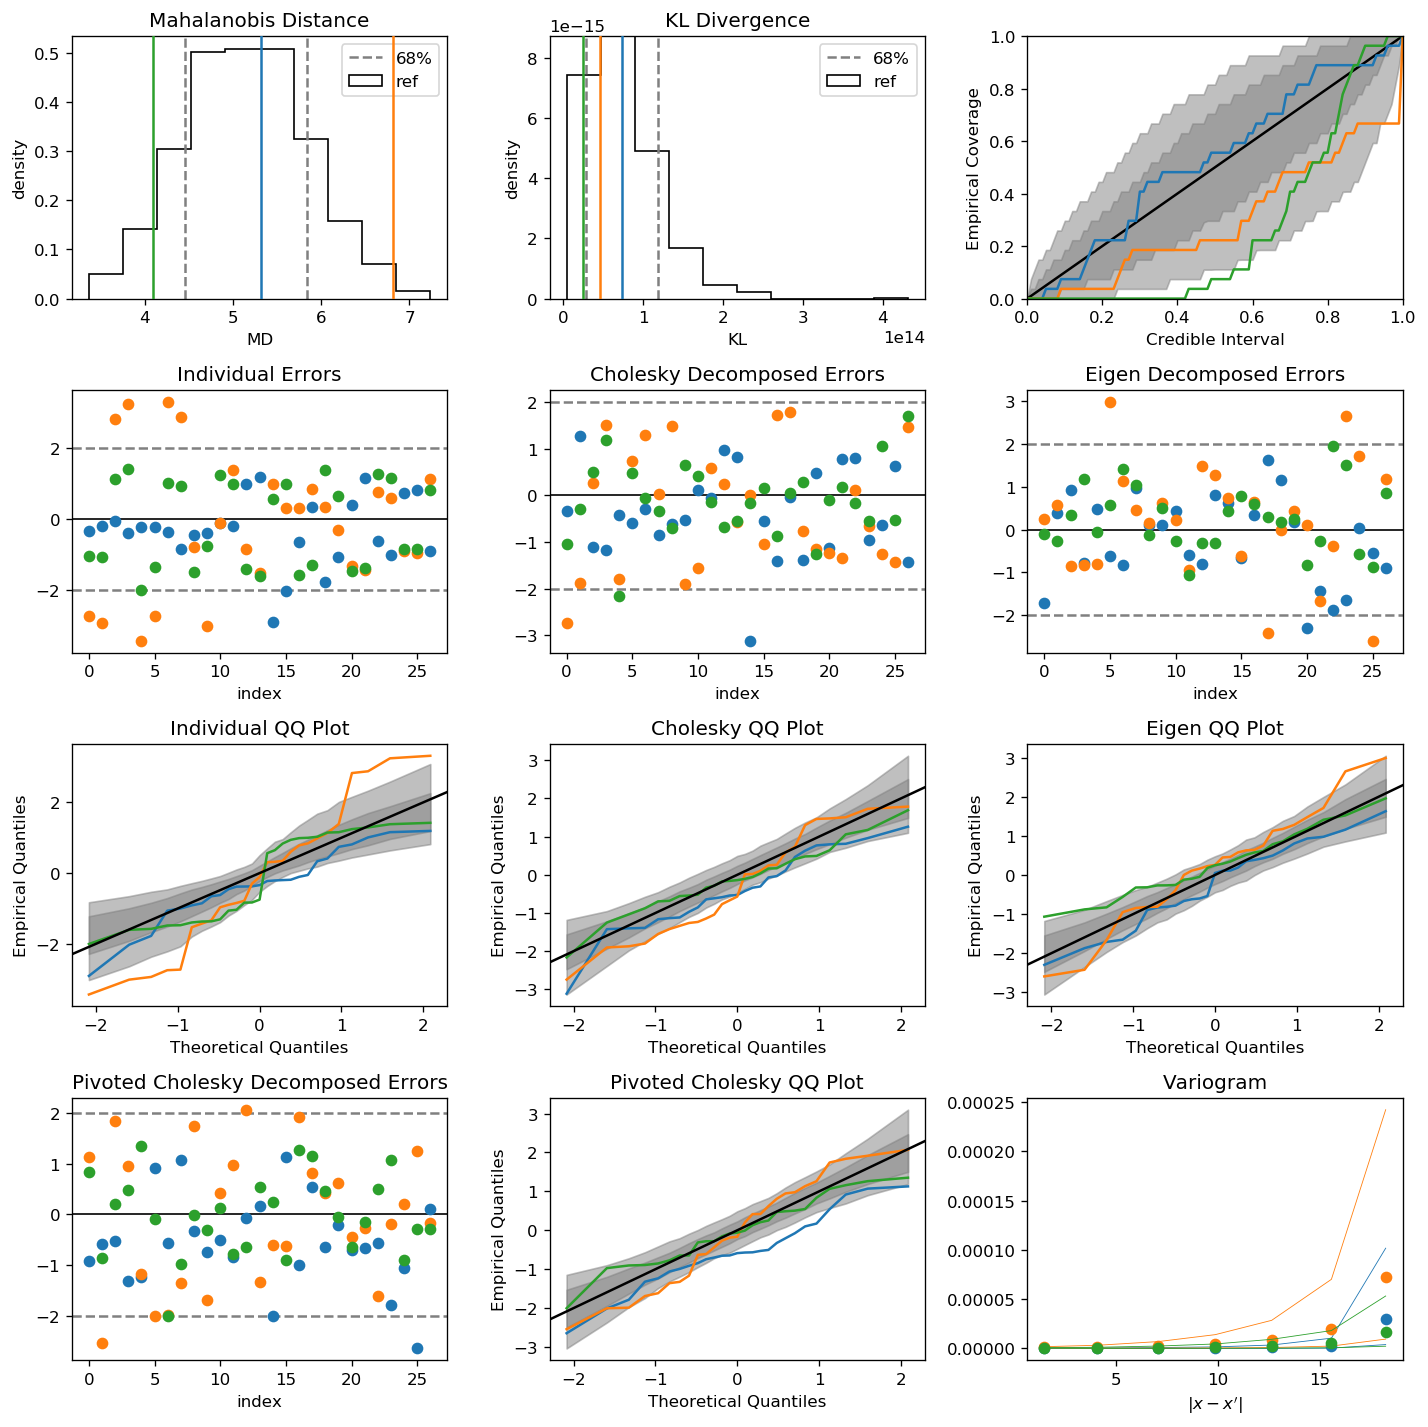

In [28]:
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test)
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

These look a bit more normal than with the two seeds considered above, in that orange is failing perhaps a bit too often, and green succeeding (suc-seed-ing?) a bit too often. 